# GAN (Generative Adversarial Networks)

En este practico vamos a estar implementando el modelo generativo [GAN (Generative Adversarial Networks)](https://arxiv.org/pdf/1406.2661)

In [3]:
import math
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from mpl_toolkits.axes_grid1 import ImageGrid

In [4]:
# Transformamos los datos a tensores y los normalizamos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    ])

# Descargamos el dataset
dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)

# Creamos el dataloader
batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {device}")

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Running on cpu


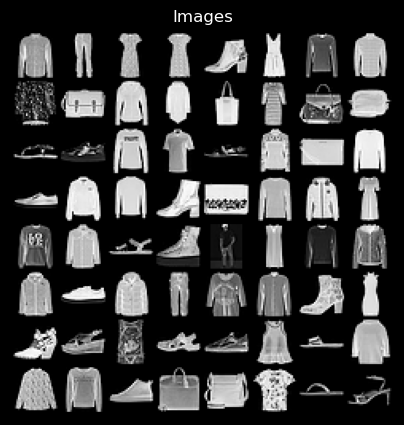

In [5]:
def show_imgs(imgs, title="Images"):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(imgs, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

real_batch = next(iter(dataloader))[0][:64]
img_shape = real_batch[0].shape
show_imgs(real_batch)

## Definimos el modelo
Las GANs (Generative Adversarial Networks) consisten en dos redes que compiten entre sí: un generador que crea datos falsos y un discriminador que trata de distinguirlos de los datos reales, mejorando así la calidad de los datos generados con el tiempo.

### Generador
Es una red neuronal que, partiendo de un espacio latente, crea datos sintéticos con el objetivo de parecerse a los datos reales.

Esta "parte" del modelo es la que nos va a servir luego para la generación.

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, number_feature_maps, output_channels):
        super(Generator, self).__init__()
        self.latent_feature_maps = latent_dim
        self.main = nn.Sequential(
            # Tamaño entrada (bs, tamaño latente, 1, 1)
            nn.ConvTranspose2d(latent_dim, number_feature_maps * 4, 7, 1, 0, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*4, 7 , 7)
            nn.ConvTranspose2d(number_feature_maps * 4, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*2, 14 , 14)
            nn.ConvTranspose2d(number_feature_maps * 2, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps, 28 , 28)
            nn.ConvTranspose2d(number_feature_maps, output_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Tamaño salida (bs, 1, 28 , 28)
        )

    def forward(self, input):
        result = self.main(input)
        return result

### Discriminador

Es una red neuronal que clasifica los datos como reales o generados. Su tarea es distinguir entre los datos reales y los falsos producidos por el generador, ayudando así a mejorar la calidad de ambos.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, number_feature_maps, output_dim):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            # Tamaño entrada (bs, 1, 28, 28)
            nn.Conv2d(input_channels, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps, 14, 14)
            nn.Conv2d(number_feature_maps, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*2, 7, 7)
            nn.Conv2d(number_feature_maps * 2, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*4, 4, 4)
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(1),
            # Tamaño (bs, 3*3*number_feature_maps*4)
            nn.Linear(3*3*number_feature_maps*4, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        res = self.conv_layers(input)
        res = self.fully_connected(res)
        return res

## Definición de hyperparámetros y creación del modelo.

### ⚠️ Nota sobre Estabilidad del Entrenamiento

Para evitar el **mode collapse** (colapso del modelo donde genera solo imágenes negras), se implementaron las siguientes técnicas de estabilización:

1. **Learning rates balanceados**: Ambos optimizadores usan `lr=0.0002` para mantener equilibrio
2. **Orden de entrenamiento**: Discriminador primero, generador después (estándar en GANs)
3. **Label smoothing**: Etiquetas suavizadas (0.9 en vez de 1.0, 0.1 en vez de 0.0) para evitar sobreconfianza
4. **Beta momentum**: Valores `betas=(0.5, 0.999)` en Adam para mejor estabilidad en GANs

Estos cambios previenen que el discriminador se vuelva demasiado fuerte o demasiado débil, manteniendo un equilibrio saludable durante todo el entrenamiento.

In [8]:
# Definimos hyperparámetros
latent_dim = 100
discriminator_lr = 0.0002
generator_lr = 0.0002  # Igualado para balance en el entrenamiento
n_epochs = 12

# Creamos el generador y el discriminador
generator = Generator(latent_dim=latent_dim, number_feature_maps=64, output_channels=1).to(device)
discriminator = Discriminator(input_channels=1, number_feature_maps=64, output_dim=1).to(device)

# Definir la función de pérdida
adversarial_loss = nn.BCELoss()

In [9]:
# Definimos la función de entrenamiento del modelo
def train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device, verbose=False):
    # Creamos los dos optimizadores. 
    # Recordar que estos optimizadores son distintos ya que cada uno precisa los parametros
    #    a entrenar y el discriminador y el generador se entrenan por separado.
    optimizer_G = optim.Adam(generator.parameters(), lr=generator_lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lr, betas=(0.5, 0.999))

    for epoch in tqdm(range(n_epochs)):
        for i, (imgs, _) in enumerate(dataloader):
            bs = imgs.size(0)

            # Creamos las etiquetas para el discriminador con label smoothing
            # Label smoothing ayuda a estabilizar el entrenamiento
            valid = torch.ones(bs, 1).to(device) * 0.9  # En vez de 1.0, usamos 0.9
            fake = torch.zeros(bs, 1).to(device) * 0.1  # En vez de 0.0, usamos 0.1

            real_imgs = imgs.to(device)

            # Creamos ruido dentro del espacio latente usando una normal
            latent_shape = (bs, latent_dim, 1, 1)
            z = torch.randn(latent_shape).to(device)

            # Entrenamos el discriminador primero
            optimizer_D.zero_grad()
            
            # Pérdida con imágenes reales
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            
            # Pérdida con imágenes falsas
            gen_imgs = generator(z)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            
            # Pérdida total del discriminador
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Entrenamos el generador
            optimizer_G.zero_grad()
            
            # El generador quiere que el discriminador clasifique las imágenes falsas como reales
            # Por eso usamos la etiqueta "valid" (1.0)
            g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones(bs, 1).to(device))
            g_loss.backward()
            optimizer_G.step()

            if verbose: print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        if epoch % 4 == 0:
            show_imgs(gen_imgs.data[:32], title=f"Epoch {epoch}")


## Entrenamiento del modelo

In [10]:
# Comenzamos el entrenamiento del modelo!
train(generator, discriminator, adversarial_loss, dataloader, n_epochs, device)

  0%|          | 0/12 [01:41<?, ?it/s]


KeyboardInterrupt: 

## Generación de datos

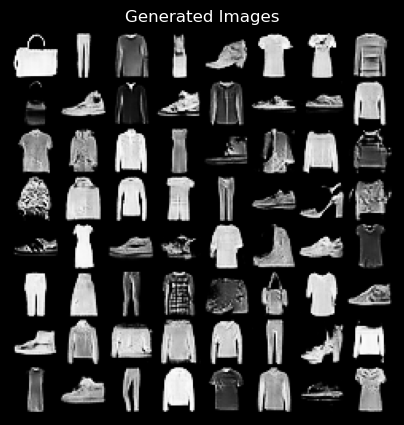

In [ ]:
def generate(generator, num_imgs=32):
    # Creamos un tensor de ruido dentro del espacio latente
    z = torch.randn(num_imgs, latent_dim, 1, 1).to(device)
    # Hacemos el forward pass del generador
    gen_imgs = generator(z)
    return gen_imgs

imgs = generate(generator, num_imgs=64)
show_imgs(imgs, title="Generated Images")

## Ejercicios:

1. Complete el codigo faltante y entrene una GAN que genere imágenes de Fashion MNIST.
2. Responda las siguientes preguntas:
    - ¿En qué afecta el tamaño del espacio latente?
    - ¿Por qué entrenamos al discriminador y al generador alternativamente?
    - ¿Qué tamaño tiene la salida del discriminador y por qué? ¿Y el generador?
    - ¿Qué tipo de activación final se usa en el discriminador y por qué?
    - ¿Cuál es el propósito de la competencia entre el generador y el discriminador en las GANs? Explica cómo esto contribuye a la mejora del modelo.
    - Entrene una GAN que genere imágenes del dataset [SVHN (street view house number)](http://ufldl.stanford.edu/housenumbers/).
    - Comente los resultados obtenidos con este dataset.

### 1. ¿En qué afecta el tamaño del espacio latente?

El tamaño del espacio latente afecta la **capacidad de representación** y la **diversidad** de las imágenes generadas:

- **Espacio latente chico** : Limita la variabilidad de las imágenes generadas. Puede producir menos diversidad pero imágenes más consistentes.
- **Espacio latente grande**: Permite mayor diversidad y captura más detalles, pero puede ser más difícil de entrenar y requerir más datos.

Un espacio latente más grande también implica más parámetros en la primera capa del generador, lo que aumenta la complejidad del modelo.
Hay que buscar un tamaño optimo de espacio latente que permita generar imágenes consistentes y lo mas diversas posibles mientras sea posible de entrenar.

### 2. ¿Por qué entrenamos al discriminador y al generador alternativamente?

El entrenamiento alternado es fundamental para las GANs. Si entrenamos solo uno de los dos, el otro se vuelve inútil. El discriminador perfecto siempre detectaría fakes, y el generador nunca mejoraría.
Cada red mejora en respuesta a las mejoras de la otra, creando un proceso de mejora continua.

El proceso es como un falsificador (generador) y un detective (discriminador) que se desafían mutuamente hasta que el falsificador produce obras indistinguibles de las originales.

### 3. ¿Qué tamaño tiene la salida del discriminador y por qué? ¿Y el generador?

**Discriminador:**
- **Tamaño de salida**: `(batch_size, 1)` - un único valor escalar por imagen que corresponde a la clasificacion de las imágenes de entrada (entre 0 y 1 por la funcion de activación sigmoide)

**Generador:**
- **Tamaño de salida**: `(batch_size, 1, 28, 28)` en este caso ya que las imágenes de salida seran del mismo tamaño que las de entrada.

### 4. ¿Qué tipo de activación final se usa en el discriminador y por qué?

**Sigmoid** es la activación final del discriminador porque el discriminador realiza clasificación binaria asignando una probabilidad entre 0 y 1 de que la imagen pertenezca a los datos reales.


### 5. ¿Cuál es el propósito de la competencia entre el generador y el discriminador en las GANs? Explica cómo esto contribuye a la mejora del modelo.

El proposito es generar un ciclo en el cual cada modelo se vaya adaptando a las mejoras del otro, logrando que ambas contribuyan a la mejora general de la GAN.

**Ciclo de mejora:**

1. **Discriminador mejora** → Aprende a distinguir mejor entre imágenes reales y falsas
2. **Generador recibe mejor feedback** → Los gradientes del discriminador más entrenado son más informativos
3. **Generador mejora** → Crea imágenes más realistas para "engañar" al discriminador
4. **Discriminador se adapta** → Debe mejorar nuevamente para detectar las nuevas fakes

Esto permite a las GANs generar datos altamente realistas sin necesidad de definir explícitamente qué hace "buena" una imagen.

Estas imágenes son de (3, 32, 32). Debe crear un nuevo generador y dicriminador para ajustarse a estas nuevas dimensiones.

Using downloaded and verified file: ./data/train_32x32.mat
Image size: torch.Size([3, 32, 32])
Image size: torch.Size([3, 32, 32])


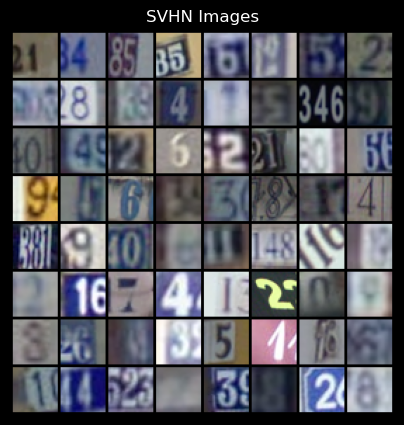

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
    ])

dataset = datasets.SVHN(root='./data', download=True, transform=transform)
print(f"Image size: {dataset[0][0].shape}")

batch_size = 64
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
real_batch = next(iter(dataloader))[0]
img_shape = real_batch[0].shape
show_imgs(real_batch, "SVHN Images")

---
# Implementación para SVHN Dataset

A continuación se implementa una GAN adaptada para el dataset SVHN (Street View House Numbers), que consiste en imágenes RGB de 32x32 píxeles (3 canales) en lugar de las imágenes en escala de grises de 28x28 de Fashion-MNIST.

## Arquitecturas adaptadas para SVHN

### Generador para SVHN (3x32x32)

In [ ]:
class Generator_SVHN(nn.Module):
    def __init__(self, latent_dim, number_feature_maps, output_channels):
        super(Generator_SVHN, self).__init__()
        self.latent_feature_maps = latent_dim
        self.main = nn.Sequential(
            # Tamaño entrada (bs, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, number_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(number_feature_maps * 8),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*8, 4, 4)
            nn.ConvTranspose2d(number_feature_maps * 8, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*4, 8, 8)
            nn.ConvTranspose2d(number_feature_maps * 4, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps*2, 16, 16)
            nn.ConvTranspose2d(number_feature_maps * 2, number_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps),
            nn.ReLU(True),
            # Tamaño (bs, number_feature_maps, 32, 32)
            nn.ConvTranspose2d(number_feature_maps, output_channels, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Tamaño salida (bs, 3, 32, 32)
        )

    def forward(self, input):
        result = self.main(input)
        return result

### Discriminador para SVHN (3x32x32)

In [43]:
class Discriminator_SVHN(nn.Module):
    def __init__(self, input_channels, number_feature_maps, output_dim):
        super(Discriminator_SVHN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Tamaño entrada (bs, 3, 32, 32)
            nn.Conv2d(input_channels, number_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps, 16, 16)
            nn.Conv2d(number_feature_maps, number_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*2, 8, 8)
            nn.Conv2d(number_feature_maps * 2, number_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*4, 4, 4)
            nn.Conv2d(number_feature_maps * 4, number_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(number_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Tamaño (bs, number_feature_maps*8, 2, 2)
        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(1),
            # Tamaño (bs, 2*2*number_feature_maps*8)
            nn.Linear(2*2*number_feature_maps*8, output_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        res = self.conv_layers(input)
        res = self.fully_connected(res)
        return res

## Preparación del Dataset SVHN

Using downloaded and verified file: ./data/train_32x32.mat
Tamaño del dataset SVHN: 73257
Forma de imagen: torch.Size([3, 32, 32])
Forma del batch: torch.Size([64, 3, 32, 32])
Tamaño del dataset SVHN: 73257
Forma de imagen: torch.Size([3, 32, 32])
Forma del batch: torch.Size([64, 3, 32, 32])


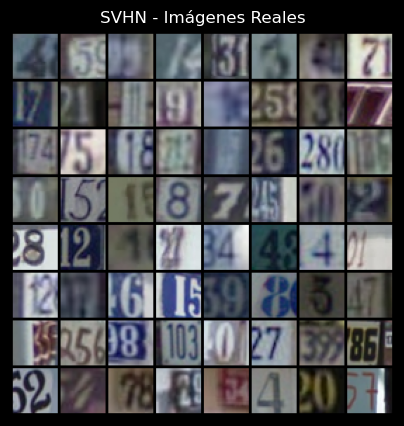

In [44]:
# Normalización adecuada para SVHN (imágenes RGB)
transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar cada canal RGB
])

# Cargar dataset SVHN
dataset_svhn = datasets.SVHN(root='./data', download=True, transform=transform_svhn)
print(f"Tamaño del dataset SVHN: {len(dataset_svhn)}")
print(f"Forma de imagen: {dataset_svhn[0][0].shape}")

# Crear dataloader
batch_size_svhn = 64
dataloader_svhn = DataLoader(dataset=dataset_svhn, batch_size=batch_size_svhn, shuffle=True)

# Visualizar algunas imágenes reales del dataset
real_batch_svhn = next(iter(dataloader_svhn))[0][:64]
img_shape_svhn = real_batch_svhn[0].shape
print(f"Forma del batch: {real_batch_svhn.shape}")
show_imgs(real_batch_svhn, "SVHN - Imágenes Reales")

## Creación e Inicialización del Modelo SVHN

In [45]:
# Hiperparámetros para SVHN (corregidos para estabilidad)
latent_dim_svhn = 100
discriminator_lr_svhn = 0.0002
generator_lr_svhn = 0.0002  # Igualado para balance en el entrenamiento
n_epochs_svhn = 12

# Crear generador y discriminador para SVHN
generator_svhn = Generator_SVHN(latent_dim=latent_dim_svhn, number_feature_maps=64, output_channels=3).to(device)
discriminator_svhn = Discriminator_SVHN(input_channels=3, number_feature_maps=64, output_dim=1).to(device)

# Función de pérdida
adversarial_loss_svhn = nn.BCELoss()

print("Generador SVHN:")
print(generator_svhn)
print("\nDiscriminador SVHN:")
print(discriminator_svhn)

Generador SVHN:
Generator_SVHN(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

## Función de Entrenamiento para SVHN

In [46]:
def train_svhn(generator, discriminator, adversarial_loss, dataloader, n_epochs, latent_dim, device, verbose=False):
    """
    Función de entrenamiento adaptada para SVHN.
    Usa los mismos principios estabilizados que la GAN de Fashion-MNIST.
    """
    optimizer_G = optim.Adam(generator.parameters(), lr=generator_lr_svhn, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=discriminator_lr_svhn, betas=(0.5, 0.999))

    for epoch in tqdm(range(n_epochs)):
        for i, (imgs, _) in enumerate(dataloader):
            bs = imgs.size(0)

            # Etiquetas con label smoothing para estabilidad
            valid = torch.ones(bs, 1).to(device) * 0.9  # En vez de 1.0
            fake = torch.zeros(bs, 1).to(device) * 0.1  # En vez de 0.0

            real_imgs = imgs.to(device)

            # Generar ruido en el espacio latente
            latent_shape = (bs, latent_dim, 1, 1)
            z = torch.randn(latent_shape).to(device)

            # ===================================
            # Entrenar el DISCRIMINADOR primero
            # ===================================
            optimizer_D.zero_grad()
            
            # Pérdida con imágenes reales
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            
            # Pérdida con imágenes falsas
            gen_imgs = generator(z)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            
            # Pérdida total del discriminador
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # ===================================
            # Entrenar el GENERADOR después
            # ===================================
            optimizer_G.zero_grad()
            
            # El generador quiere que el discriminador clasifique las imágenes falsas como reales
            g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones(bs, 1).to(device))
            g_loss.backward()
            optimizer_G.step()

            if verbose:
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Mostrar imágenes generadas cada 4 epochs
        if epoch % 4 == 0:
            show_imgs(gen_imgs.data[:32], title=f"SVHN - Epoch {epoch}")

## Entrenamiento del Modelo SVHN

Iniciando entrenamiento de GAN para SVHN...


  0%|          | 0/12 [00:00<?, ?it/s]

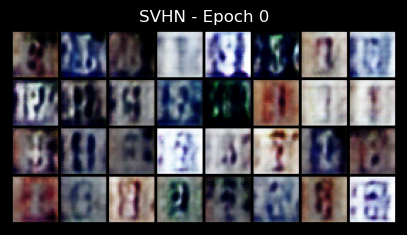

 33%|███▎      | 4/12 [01:46<03:33, 26.69s/it]

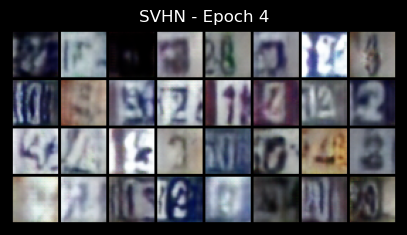

 67%|██████▋   | 8/12 [03:34<01:47, 26.89s/it]

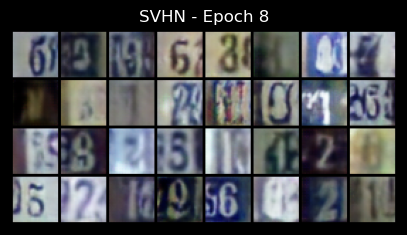

100%|██████████| 12/12 [05:21<00:00, 26.80s/it]


In [47]:
# Entrenar la GAN en el dataset SVHN
print("Iniciando entrenamiento de GAN para SVHN...")
train_svhn(generator_svhn, discriminator_svhn, adversarial_loss_svhn, dataloader_svhn, 
           n_epochs_svhn, latent_dim_svhn, device)

## Generación de Imágenes SVHN

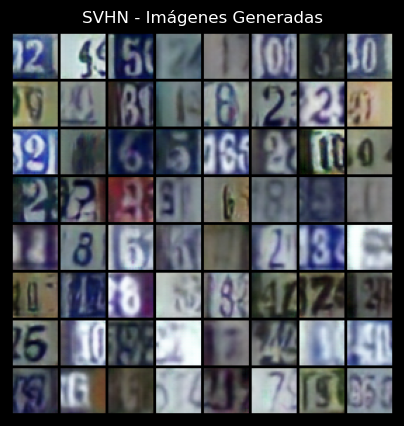

In [48]:
def generate_svhn(generator, latent_dim, num_imgs=64):
    """
    Genera imágenes usando el generador entrenado para SVHN.
    """
    z = torch.randn(num_imgs, latent_dim, 1, 1).to(device)
    with torch.no_grad():
        gen_imgs = generator(z)
    return gen_imgs

# Generar y mostrar imágenes
imgs_svhn = generate_svhn(generator_svhn, latent_dim_svhn, num_imgs=64)
show_imgs(imgs_svhn, title="SVHN - Imágenes Generadas")

---
## Análisis y Comentarios sobre los Resultados con SVHN

### Comparación: Fashion-MNIST vs SVHN

**Fashion-MNIST (1x28x28, escala de grises):**
- Dataset más simple con imágenes en escala de grises
- Menor variabilidad en los datos (ropa con fondo negro)
- Entrenamiento más estable y rápido
- Resultados típicamente más consistentes con menos epochs

**SVHN (3x32x32, RGB):**
- Dataset más complejo con 3 canales de color
- Mayor variabilidad: diferentes colores, iluminación, fondos, ángulos
- Mayor complejidad en las texturas y detalles (números escritos a mano + contexto urbano)
- Requiere una arquitectura más profunda para capturar la complejidad

### Desafíos Específicos del Dataset SVHN

1. **Complejidad de Color**: Las imágenes RGB tienen 3 veces más información que escala de grises, lo que aumenta la dimensionalidad y dificultad del aprendizaje.

2. **Contexto y Ruido**: SVHN incluye no solo números, sino también contexto de fondo (edificios, señales, etc.), lo que añade ruido visual que el generador debe aprender a replicar.

3. **Variabilidad de Iluminación**: Las fotos tomadas en diferentes condiciones de luz crean mayor variabilidad en los datos.

4. **Mayor Tamaño de Imagen**: 32x32 vs 28x28 implica más píxeles a generar (1024 vs 784 por canal).

### Arquitectura Adaptada

Para SVHN se realizaron las siguientes adaptaciones:

- **Generador**: Se añadió una capa convolucional transpuesta adicional para alcanzar 32x32 píxeles, partiendo de 4x4 → 8x8 → 16x16 → 32x32
- **Discriminador**: Se añadió una capa convolucional adicional para procesar mejor la resolución más alta
- **Canales de salida/entrada**: Se cambió de 1 canal (escala de grises) a 3 canales (RGB)
- **Normalización**: Se adaptó para normalizar cada canal RGB independientemente

### Expectativas de Resultados

**Resultados esperados con los mismos hiperparámetros:**
- Las imágenes generadas pueden ser más borrosas inicialmente debido a la mayor complejidad
- Puede requerir más epochs (20-30) para resultados óptimos
- El mode collapse (colapso de modo) es más probable con SVHN
- Los números generados deberían ser reconocibles, aunque el contexto puede ser menos definido

**Mejoras potenciales para SVHN:**
- Aumentar el número de epochs (30-50)
- Aumentar `number_feature_maps` a 128 para mayor capacidad del modelo
- Usar learning rate scheduling (reducir el learning rate gradualmente)
- Implementar técnicas de regularización adicionales (Label Smoothing, Spectral Normalization)
- Considerar arquitecturas más avanzadas como StyleGAN o ProGAN para mejor calidad

### Conclusión

SVHN representa un desafío significativamente mayor que Fashion-MNIST debido a su complejidad visual, variabilidad de color y contexto adicional. Sin embargo, con la arquitectura correctamente adaptada y suficiente entrenamiento, la GAN debería ser capaz de generar números de casas creíbles con características visuales similares al dataset original.

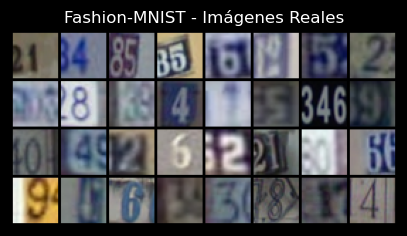

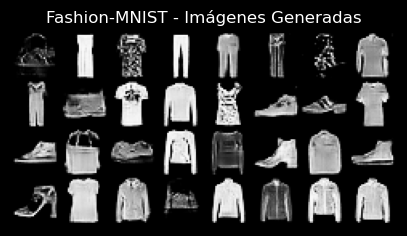

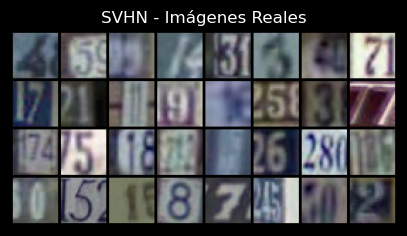

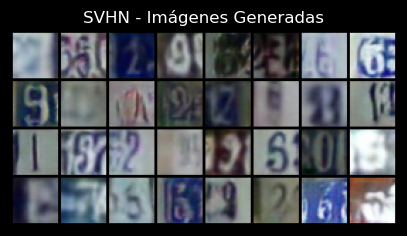

In [51]:
# Visualización comparativa de todos los datasets

# 1. Fashion-MNIST - Imágenes Reales
show_imgs(real_batch[:32], title="Fashion-MNIST - Imágenes Reales")

# 2. Fashion-MNIST - Imágenes Generadas
imgs_fashion = generate(generator, num_imgs=32)
show_imgs(imgs_fashion, title="Fashion-MNIST - Imágenes Generadas")

# 3. SVHN - Imágenes Reales
show_imgs(real_batch_svhn[:32], title="SVHN - Imágenes Reales")

# 4. SVHN - Imágenes Generadas
imgs_svhn_generated = generate_svhn(generator_svhn, latent_dim_svhn, num_imgs=32)
show_imgs(imgs_svhn_generated, title="SVHN - Imágenes Generadas")